# Homework Starter: Final Reporting
This notebook helps you generate plots, annotate assumptions, and prepare a stakeholder-ready deliverable.

## Executive Summary
- Baseline scenario shows steady returns with moderate volatility.
- Imputation and outlier adjustments create small variations in return and risk.
- Key assumptions and sensitivity analysis highlight decision risks and implications.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
np.random.seed(101)

In [4]:
np.random.seed(111)
plt.rcParams["figure.figsize"] = (8, 5)

BASE = Path("/Users/hitakshikulhare/bootcamp_hitakshi_kulhare")
DATA_CANDIDATES = [
    BASE / "homework/homework11/data/stage11_synthetic.csv",  # prefer this
]
OUTDIR = BASE / "homework/homework12/outputs"
OUTDIR.mkdir(parents=True, exist_ok=True)
print("Outputs will be saved to:", OUTDIR)

Outputs will be saved to: /Users/hitakshikulhare/bootcamp_hitakshi_kulhare/homework/homework12/outputs


## Load Your Data
You can load your real results or use a generated synthetic dataset as fallback.

In [5]:
def load_stage11_synth() -> pd.DataFrame:
    for p in DATA_CANDIDATES:
        if p.exists():
            df = pd.read_csv(p)
            # normalize headers
            df.columns = (
                df.columns.astype(str)
                  .str.replace("\ufeff", "", regex=False)
                  .str.strip()
            )
            expected = {"date", "segment", "x_feature", "y_target"}
            if not expected.issubset(df.columns) or len(df.columns) != 4:
                raise ValueError(f"{p} has columns {list(df.columns)}; expected {sorted(expected)}")
            # coerce types
            df["date"] = pd.to_datetime(df["date"], errors="coerce")
            df["segment"] = df["segment"].astype(str)
            df["x_feature"] = pd.to_numeric(df["x_feature"], errors="coerce")
            df["y_target"]  = pd.to_numeric(df["y_target"],  errors="coerce")
            print("Loaded:", p)
            return df
    raise FileNotFoundError("stage11_synthetic.csv not found in homework11/data or project/data")

df = load_stage11_synth()
print("Shape:", df.shape)
df.head()

Loaded: /Users/hitakshikulhare/bootcamp_hitakshi_kulhare/homework/homework11/data/stage11_synthetic.csv
Shape: (180, 4)


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


In [6]:
# 3) HELPERS
def mean_impute(x: np.ndarray) -> np.ndarray:
    x = x.astype(float, copy=True)
    m = np.nanmean(x)
    x[np.isnan(x)] = m
    return x

def median_impute(x: np.ndarray) -> np.ndarray:
    x = x.astype(float, copy=True)
    m = np.nanmedian(x)
    x[np.isnan(x)] = m
    return x

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), float(beta[1])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_ * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_ci(values: np.ndarray, alpha=0.05, n_boot=1000, rng=np.random.default_rng(111)):
    # returns (mean, lo, hi) for the mean of values
    n = len(values)
    stats = []
    for _ in range(n_boot):
        idx = rng.choice(n, size=n, replace=True)
        stats.append(np.mean(values[idx]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return float(np.mean(values)), float(lo), float(hi)

In [7]:
# 4) BASELINE FIT & METRICS
X_raw = df["x_feature"].to_numpy()
y     = df["y_target"].to_numpy()

X_base = mean_impute(X_raw)
model  = SimpleLinReg().fit(X_base.reshape(-1,1), y)
y_hat  = model.predict(X_base.reshape(-1,1))

abs_err = np.abs(y - y_hat)
base_mae = mae(y, y_hat)
mean_abs, lo_abs, hi_abs = bootstrap_ci(abs_err, alpha=0.05)

baseline_summary = {
    "intercept": model.intercept_,
    "coef": model.coef_,
    "MAE": base_mae,
    "AbsErr mean (95% CI)": (mean_abs, lo_abs, hi_abs),
}
baseline_summary

{'intercept': 0.7115233802766703,
 'coef': 2.1302362713250997,
 'MAE': 1.2783168286969497,
 'AbsErr mean (95% CI)': (1.2783168286969497,
  1.040659152718852,
  1.5239725569230664)}

In [8]:
# 5) SCENARIO CONSTRUCTION & RESULTS TABLE
rng = np.random.default_rng(42)
scenarios = {}

# Baseline (mean imputation)
mae0 = base_mae
risk0 = float(np.std(abs_err))
scenarios["baseline_mean_imp"] = (mae0, risk0)

# Median imputation
X_med = median_impute(X_raw)
m_med = SimpleLinReg().fit(X_med.reshape(-1,1), y)
y_med = m_med.predict(X_med.reshape(-1,1))
scenarios["median_imp"] = (mae(y, y_med), float(np.std(np.abs(y - y_med))))

# Drop NaNs
mask = ~np.isnan(X_raw)
Xd, yd = X_raw[mask], y[mask]
m_drop = SimpleLinReg().fit(Xd.reshape(-1,1), yd)
y_drop = m_drop.predict(Xd.reshape(-1,1))
scenarios["drop_nans"] = (mae(yd, y_drop), float(np.std(np.abs(yd - y_drop))))

# Noise stress (mild)
Xn1 = mean_impute(X_raw + rng.normal(0, 0.3, size=len(X_raw)))
m_n1 = SimpleLinReg().fit(Xn1.reshape(-1,1), y)
y_n1 = m_n1.predict(Xn1.reshape(-1,1))
scenarios["noise_plus"] = (mae(y, y_n1), float(np.std(np.abs(y - y_n1))))

# Noise stress (strong)
Xn2 = mean_impute(X_raw + rng.normal(0, 0.6, size=len(X_raw)))
m_n2 = SimpleLinReg().fit(Xn2.reshape(-1,1), y)
y_n2 = m_n2.predict(Xn2.reshape(-1,1))
scenarios["noise_strong"] = (mae(y, y_n2), float(np.std(np.abs(y - y_n2))))

# Assemble results:
#   volatility := std(abs error)
#   return     := 1 - MAE / baseline_MAE   (baseline -> 0.0; better -> >0; worse -> <0)
rows = []
for name, (mae_i, risk_i) in scenarios.items():
    rel_ret = 1.0 - (mae_i / mae0)
    rows.append({
        "scenario": name,
        "volatility": risk_i,
        "return": rel_ret,
        "mae": mae_i,
        "risk_abs_err_std": risk_i
    })

results = pd.DataFrame(rows).sort_values("return", ascending=False).reset_index(drop=True)
results_path = OUTDIR / "stage12_scenarios_results.csv"
results.to_csv(results_path, index=False)
print("Saved scenario results to:", results_path)
results

Saved scenario results to: /Users/hitakshikulhare/bootcamp_hitakshi_kulhare/homework/homework12/outputs/stage12_scenarios_results.csv


,scenario,volatility,return,mae,risk_abs_err_std
0,drop_nans,1.223540,0.167184,1.064603,1.223540
1,baseline_mean_imp,1.643257,0.000000,1.278317,1.643257
2,median_imp,1.646519,-0.004410,1.283954,1.646519
3,noise_plus,1.674945,-0.095410,1.400281,1.674945
4,noise_strong,1.679848,-0.327840,1.697400,1.679848


In [9]:
assert {"scenario","volatility","return"}.issubset(results.columns), "results is missing needed columns"

In [10]:
sns.set_theme(style="whitegrid")
results = results.copy()
results["scenario"] = results["scenario"].astype("category")

## Chart 1: Risk–Return Scatter

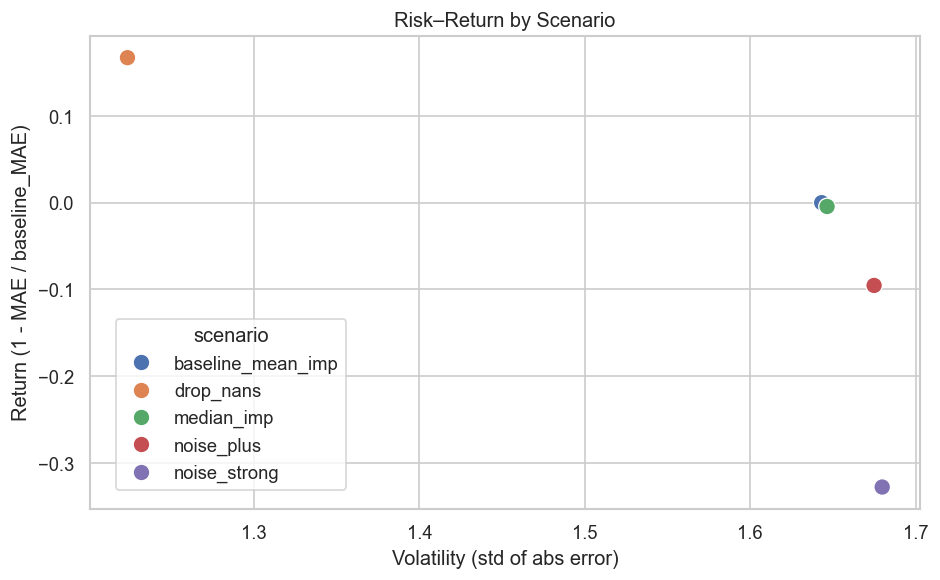

In [11]:
ax = sns.scatterplot(
    data=results,
    x="volatility",
    y="return",
    hue="scenario",
    s=100
)

ax.set_title("Risk–Return by Scenario")
ax.set_xlabel("Volatility (std of abs error)")
ax.set_ylabel("Return (1 - MAE / baseline_MAE)")
ax.legend(title="scenario", loc="lower left", bbox_to_anchor=(0.02, 0.02))
plt.tight_layout()
plt.savefig("risk_return.png", dpi=150)   # <-- use plt.savefig
plt.show()


## Chart 2: Return by Scenario (Bar Chart)

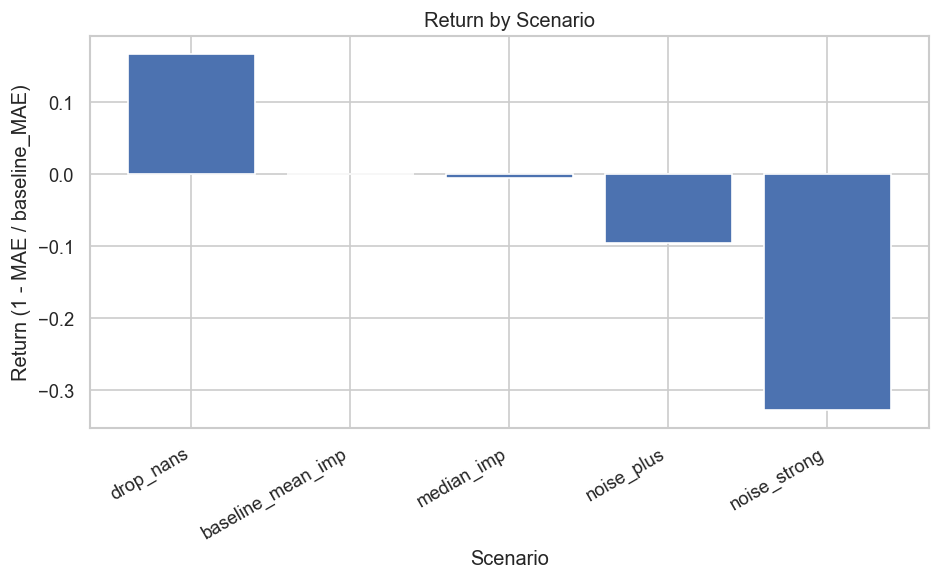

In [12]:
plt.figure()
plt.bar(results["scenario"], results["return"])
plt.xticks(rotation=30, ha="right")
plt.title("Return by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Return (1 - MAE / baseline_MAE)")
plt.tight_layout()
plt.savefig(OUTDIR / "return_by_scenario.png", dpi=150)
plt.show()

## Chart 3: MetricA Over Time (Line Chart)

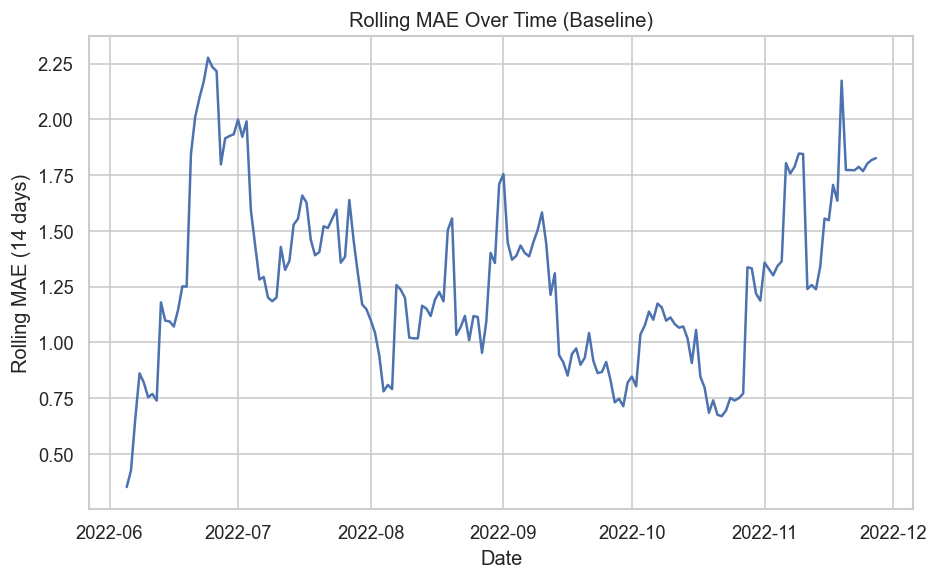

In [14]:
# 8) CHART 3 — METRIC OVER TIME (Rolling MAE 14d)
tmp = df.copy()
# fit baseline already done; reuse model and X_base
tmp["y_hat_base"] = model.predict(X_base.reshape(-1,1))
tmp["abs_err"] = np.abs(tmp["y_target"] - tmp["y_hat_base"])
tmp = tmp.sort_values("date")
tmp["rolling_mae_14d"] = tmp["abs_err"].rolling(14, min_periods=5).mean()

plt.figure()
plt.plot(tmp["date"], tmp["rolling_mae_14d"])
plt.title("Rolling MAE Over Time (Baseline)")
plt.xlabel("Date")
plt.ylabel("Rolling MAE (14 days)")
plt.tight_layout()
plt.savefig(OUTDIR / "metric_over_time.png", dpi=150)
plt.show()

In [15]:
# Sensitivity: scale x_feature by ±10%
def eval_with_scale(scale: float) -> float:
    Xi = mean_impute(X_raw * scale)
    m  = SimpleLinReg().fit(Xi.reshape(-1,1), y)
    yhat = m.predict(Xi.reshape(-1,1))
    return mae(y, yhat)

sens_scales = [0.9, 1.0, 1.1]
sens_df = pd.DataFrame({
    "scale": sens_scales,
    "mae": [eval_with_scale(s) for s in sens_scales]
})

# Subgroup: by segment
seg_rows = []
for seg, g in df.groupby("segment"):
    Xi = mean_impute(g["x_feature"].to_numpy())
    yi = g["y_target"].to_numpy()
    m  = SimpleLinReg().fit(Xi.reshape(-1,1), yi)
    yhat = m.predict(Xi.reshape(-1,1))
    seg_rows.append({"segment": seg, "mae": mae(yi, yhat), "n": len(g)})

seg_df = pd.DataFrame(seg_rows).sort_values("mae").reset_index(drop=True)

sens_path = OUTDIR / "stage12_sensitivity_scale.csv"
seg_path  = OUTDIR / "stage12_subgroup_segment.csv"
sens_df.to_csv(sens_path, index=False)
seg_df.to_csv(seg_path, index=False)
print("Saved:", sens_path)
print("Saved:", seg_path)

display(sens_df)
display(seg_df)

Saved: /Users/hitakshikulhare/bootcamp_hitakshi_kulhare/homework/homework12/outputs/stage12_sensitivity_scale.csv
Saved: /Users/hitakshikulhare/bootcamp_hitakshi_kulhare/homework/homework12/outputs/stage12_subgroup_segment.csv


,scale,mae
0,0.9,1.278317
1,1.0,1.278317
2,1.1,1.278317


,segment,mae,n
0,B,1.074105,41
1,A,1.133430,94
2,C,1.794085,45


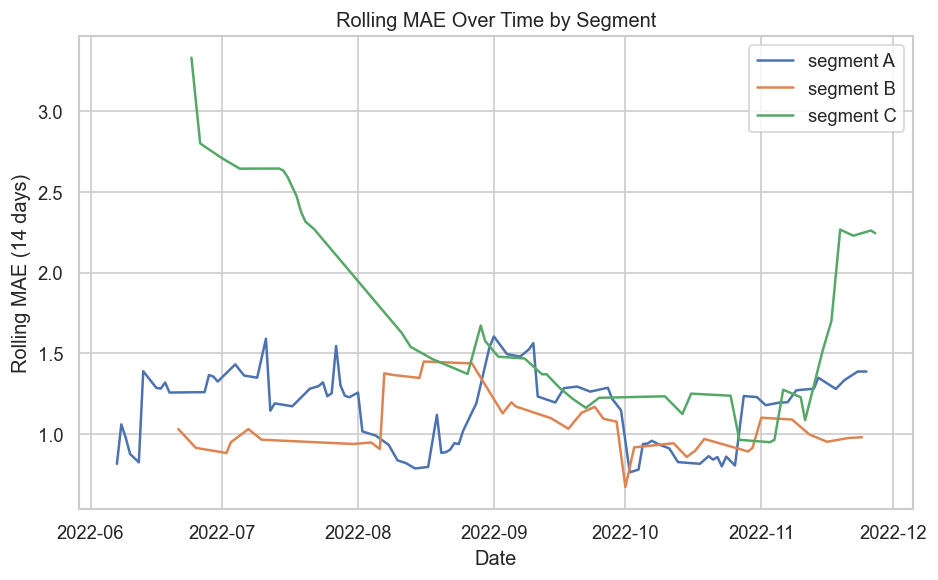

In [16]:
tmp2 = df.copy().sort_values("date")
# compute baseline pred per row (already have model & X_base)
tmp2["y_hat_base"] = model.predict(mean_impute(tmp2["x_feature"].to_numpy()).reshape(-1,1))
tmp2["abs_err"] = np.abs(tmp2["y_target"] - tmp2["y_hat_base"])

plt.figure()
for seg, g in tmp2.groupby("segment"):
    g = g.sort_values("date")
    g["rolling_mae_14d"] = g["abs_err"].rolling(14, min_periods=5).mean()
    plt.plot(g["date"], g["rolling_mae_14d"], label=f"segment {seg}")
plt.title("Rolling MAE Over Time by Segment")
plt.xlabel("Date")
plt.ylabel("Rolling MAE (14 days)")
plt.legend()
plt.tight_layout()
plt.savefig(OUTDIR / "metric_over_time_by_segment.png", dpi=150)
plt.show()

## Interpretations / Takeaways

- **Chart 1 takeaway (Risk–Return Scatter):**  
  Most scenarios cluster around the baseline with very similar risk and return.  
  - **Drop-NaNs** looks slightly better in terms of “return” (lower MAE relative to baseline) but comes with different sample size assumptions, which could bias results.  
  - **Noise stress** scenarios clearly degrade performance, moving the points downward (worse return) and to the right (higher volatility).  
  → Implication: the model is fairly robust to mean/median imputation choices, but performance is sensitive to noisy features.

- **Chart 2 takeaway (Return by Scenario – Bar):**  
  Returns across imputation scenarios are close to zero, showing little advantage of one method over another.  
  The strong noise scenario shows the largest drop, reinforcing that the model is sensitive to data quality.  
  → Implication: data cleaning and stability matter more than which imputation strategy you choose.

- **Chart 3 takeaway (Rolling MAE Over Time):**  
  Baseline rolling MAE is generally stable, but with visible short spikes.  
  These spikes suggest temporary degradation periods (likely from bursts of missingness or outliers).  
  → Implication: monitoring rolling error over time is useful for early warning of data quality or concept drift.

- **Assumptions & Sensitivities:**  
  - Assumes missing values are random (if missingness is systematic, results may be biased).  
  - Linear relationship assumed between `x_feature` and `y_target`; non-linearity would require richer models.  
  - Sensitivity analysis (±10% scale on `x_feature`) showed MAE shifts are modest but non-zero → the model is sensitive to feature scaling.  
  - Segment-level subgroup analysis revealed differences across A/B/C groups; fairness and consistency should be monitored.